In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from simulation import simulation
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Solve HJB

In [13]:
# Intensity parameter
τ = 1.

r1 = -19.5001
r0 = -1.0957 / τ

# Robustness parameters
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 1.
y_step = .01
y_grid_long = np.arange(0., y_bar_upper*2, y_step)
y_grid_short = np.arange(0., y_bar_upper, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc]

In [14]:
# Parallelly solve ODE
model_args_low = []
model_args_high = []
model_args_extreme = []

model_paras_low = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[0], y_bar_upper)

for y_jump in y_grid_tilde:
    model_paras_high = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[1], y_jump)
    model_paras_extreme = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[2], y_jump)
    model_args_high.append((y_grid_long, model_paras_high, None, ϵ, 1e-8, 5000, False))
    model_args_extreme.append((y_grid_long, model_paras_extreme, None, ϵ, 1e-8, 5000, False))

print('----- Solving low damage model -----')
model_low = ode_y(y_grid_long, model_paras_low, None, ϵ, 1e-8, 5000, False)
print('----- Solving high damage models -----')
model_high_list = ode_y_parallel(model_args_high)
print('----- Solving extreme damage models -----')
model_extreme_list = ode_y_parallel(model_args_extreme)

----- Solving low damage model -----
Converged. Total iteration 5000: LHS Error: 3.148128313057441e-05; RHS Error 8.127517118952654e-05
----- Solving high damage models -----
----- Solving extreme damage models -----


In [15]:
# Prepare ϕ_m
ϕ_m = np.zeros((3, len(y_grid_short)))
for i in range(len(y_grid_tilde)):
    ϕ_m[0, y_bar_lower_loc+i] = model_low['v0'][y_bar_lower_loc+i]
    ϕ_m[1, y_bar_lower_loc+i] = model_high_list[i]['v0'][y_bar_lower_loc+i]
    ϕ_m[2, y_bar_lower_loc+i] = model_extreme_list[i]['v0'][y_bar_lower_loc+i]

In [16]:
temp_1 = model_low['v0'][:y_bar_upper_loc]
temp_2 = model_high_list[-1]['v0'][:y_bar_upper_loc]
temp_3 = model_extreme_list[-1]['v0'][:y_bar_upper_loc]
v_guess = np.average(np.array([temp_1, temp_2, temp_3]), weights=πd_o, axis=0)

In [17]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = -η*(y_grid+y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = r0 * (np.exp(r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        g = np.exp(1./ξ_2m*(v0-ϕ_i))

        A = np.ones_like(y_grid)*(-δ)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0) - np.exp(-1./ξ_2m * v0)) \
                / np.exp(-1./ξ_2m * v0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [18]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=500, print_all=True)

Iteration 1: LHS Error: 1.1690463691833701; RHS Error 1.1697403168206335
Iteration 2: LHS Error: 0.40876451538085856; RHS Error 0.4112385085593035
Iteration 3: LHS Error: 0.26539369830249626; RHS Error 0.26782748974570686
Iteration 4: LHS Error: 0.1997982631871824; RHS Error 0.20254566601032056
Iteration 5: LHS Error: 0.162352211288034; RHS Error 0.16469659047595048
Iteration 6: LHS Error: 0.13809658733282815; RHS Error 0.14084800301082934
Iteration 7: LHS Error: 0.12121938567896917; RHS Error 0.12402053080745784
Iteration 8: LHS Error: 0.10892558233879246; RHS Error 0.1114851718662663
Iteration 9: LHS Error: 0.09941581404266353; RHS Error 0.10210716466564519
Iteration 10: LHS Error: 0.09173078957573444; RHS Error 0.09480572012035526
Iteration 11: LHS Error: 0.08602121347069769; RHS Error 0.08841586917227545
Iteration 12: LHS Error: 0.0806919925709253; RHS Error 0.08379439489911897
Iteration 13: LHS Error: 0.07697453020199574; RHS Error 0.0793966318346206
Iteration 14: LHS Error: 0.073

Iteration 148: LHS Error: 0.008581255114351372; RHS Error 0.008421077439312537
Iteration 149: LHS Error: 0.008480316484398731; RHS Error 0.008320154466786293
Iteration 150: LHS Error: 0.008379436087282865; RHS Error 0.008221975964041742
Iteration 151: LHS Error: 0.008277022461122385; RHS Error 0.008123710922715466
Iteration 152: LHS Error: 0.008178671197433651; RHS Error 0.008028204009800102
Iteration 153: LHS Error: 0.008084455018300574; RHS Error 0.007932876385886196
Iteration 154: LHS Error: 0.007987691695832133; RHS Error 0.007839350551632603
Iteration 155: LHS Error: 0.007893111983521273; RHS Error 0.007746803942696737
Iteration 156: LHS Error: 0.007799885323659161; RHS Error 0.007655206424742128
Iteration 157: LHS Error: 0.007703843888228423; RHS Error 0.007565533721456741
Iteration 158: LHS Error: 0.007613076447812617; RHS Error 0.007476552126260624
Iteration 159: LHS Error: 0.007522954144182137; RHS Error 0.007389026708223639
Iteration 160: LHS Error: 0.007434397212399357; RHS 

Iteration 292: LHS Error: 2.984966648966747e-06; RHS Error 0.0025373871221869918
Iteration 293: LHS Error: 2.944122495129875e-06; RHS Error 0.002537386853176376
Iteration 294: LHS Error: 2.904202406117662e-06; RHS Error 0.002537386580643102
Iteration 295: LHS Error: 2.8644135947608618e-06; RHS Error 0.00253738630376742
Iteration 296: LHS Error: 2.826092021734894e-06; RHS Error 0.0025373860217739533
Iteration 297: LHS Error: 2.787752175326119e-06; RHS Error 0.002537385733899101
Iteration 298: LHS Error: 2.7505884587775142e-06; RHS Error 0.0025373854393896667
Iteration 299: LHS Error: 2.713657752284604e-06; RHS Error 0.0025373851375189854
Iteration 300: LHS Error: 2.6776159813834965e-06; RHS Error 0.002537384827584581
Iteration 301: LHS Error: 2.6419659682197505e-06; RHS Error 0.002537384508941032
Iteration 302: LHS Error: 2.6070781613540817e-06; RHS Error 0.0025373841810237864
Iteration 303: LHS Error: 2.5725880532512235e-06; RHS Error 0.0025373838433783436
Iteration 304: LHS Error: 2.5

## Simulation

In [19]:
e_grid_no_jump = model_res['e_tilde']
e_grid_jump_low = np.array([model_low['e_tilde'] for model in model_high_list])
e_grid_jump_high = np.array([model['e_tilde'] for model in model_high_list])
e_grid_jump_extreme = np.array([model['e_tilde'] for model in model_extreme_list])
e_grid_jump = np.array([e_grid_jump_low, e_grid_jump_high, e_grid_jump_extreme])

In [31]:
@njit
def simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                        θ, y0, y_bar_lower, r0, r1, τ, damage_prob, T=80):
    """
    y_grid : (N,) ndarray
    e_grid_no_jump : (N,) ndarray
    e_grid_jump : (3, M, N) ndarray
        e_grid[0, i], e_grid[1, i] and e_grid[2, i] are the emissions conditional
            on low, high and extreme damages when jump occurrs at y_grid_tilde[i].
    """
    yt = np.zeros(T+1)
    et = np.zeros(T+1)
    jump_occurred = False
    e_grid_realized = e_grid_no_jump
    for i in range(T+1):
        if y0 > y_bar_lower and jump_occurred == False:
            intensity = r0 * (np.exp(r1 / 2. * (y0-y_bar_lower)**2) - 1.)
            jump_prob = τ * intensity
            realized_jump_state = np.random.multinomial(n=1, pvals=np.array([jump_prob, 1-jump_prob]))
            if np.array_equal(realized_jump_state, np.array([1, 0])):
                jump_occurred = True
                realized_damage_state = np.random.multinomial(n=1, pvals=damage_prob)
                loc = find_nearest_value(y_grid_tilde, y0)
                if np.array_equal(realized_damage_state, np.array([1, 0, 0])):
                    e_grid_realized = e_grid_jump[0, loc]
                elif np.array_equal(realized_damage_state, np.array([0, 1, 0])):
                    e_grid_realized = e_grid_jump[1, loc]
                else:
                    e_grid_realized = e_grid_jump[2, loc]
        if jump_occurred:
            et[i] = np.interp(y0, y_grid_long, e_grid_realized)
        else:
            et[i] = np.interp(y0, y_grid_short, e_grid_realized)
        yt[i] = y0
        y0 = y0 + et[i]*θ
    return et, yt

@njit
def simulation_n_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                      θ, y0, y_bar_lower, r0, r1, τ, damage_prob, T=80, N=10_000):
    yt_n_path = np.zeros((N, T+1))
    et_n_path = np.zeros((N, T+1))
    for n in range(N):
        et, yt = simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                                     θ, y0, y_bar_lower, r0, r1, τ, damage_prob, T=T)
        yt_n_path[n] = yt
        et_n_path[n] = et
    return et_n_path, yt_n_path

In [46]:
# et, yt = simulation_one_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
#                              np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, r0=r0,
#                              r1=r1, τ=τ, damage_prob=np.array([1./3, 1./3, 1./3]), T=80)

et, yt = simulation_n_path(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                           np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, r0=r0,
                           r1=r1, τ=τ, damage_prob=np.array([1./3, 1./3, 1./3]), T=80, N=1_000_000)

In [47]:
et_10 = np.percentile(et, 10, axis=0)
et_50 = np.percentile(et, 50, axis=0)
et_90 = np.percentile(et, 90, axis=0)

Text(0.5, 1.0, 'Emission')

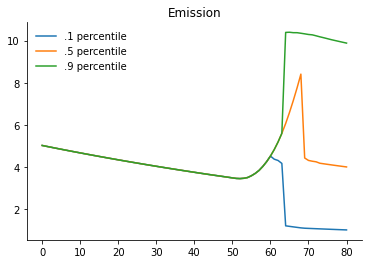

In [48]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.legend(frameon=False)
plt.title('Emission')

In [51]:
et_no_jump, yt_no_jump, _, _ = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=89)

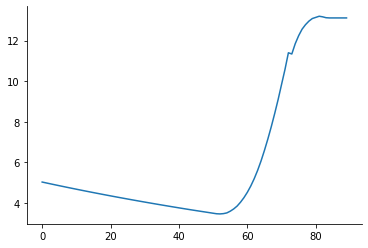

In [52]:
plt.plot(et_no_jump)

## Old plots

In [ ]:
plt.plot(y_grid_short[40:], model_res['πd'][0][40:], label='low damage')
plt.plot(y_grid_short[40:], model_res['πd'][1][40:], label='high damage')
plt.plot(y_grid_short[40:], model_res['πd'][2][40:], label='extreme damage')
plt.legend(frameon=False)
plt.ylim(0, 1)

In [ ]:
plt.plot(y_grid_short, model_res['e_tilde'])
plt.title('Figure 1: Emission')
plt.xlabel('y')
plt.savefig('fig_1.pdf')

In [ ]:
plt.plot(y_grid_short, model_res['v0_dy'])
plt.title(r'Figure 2: $\frac{d\phi}{dy}(y)$')
plt.xlabel('y')
plt.savefig('fig_2.pdf')

In [ ]:
plt.plot(y_grid_short, model_res['intensity'])
plt.title('Figure 3: Intensity')
plt.xlabel('y')
plt.savefig('fig_3.pdf')

In [ ]:
plt.plot(y_grid_short, model_res['v0'])
plt.title(r'Figure 4: Value function $\phi(y)$')
plt.xlabel('y')
plt.savefig('fig_4.pdf')

In [ ]:
et, yt, ht, gt = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
plt.plot(et)

In [ ]:
# Compute model high/extreme at 1.6, 1.8, 2.0
model_args_high_new = []
model_args_extreme_new = []

for y_jump in [1.6, 1.8, 2.0]:
    model_paras_high = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[1], y_jump)
    model_paras_extreme = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[2], y_jump)
    model_args_high_new.append((np.arange(0., y_bar_upper*2, .01), model_paras_high, None, ϵ, 1e-8, 5000, False))
    model_args_extreme_new.append((np.arange(0., y_bar_upper*2, .01), model_paras_extreme, None, ϵ, 1e-8, 5000, False))

print('----- Solving high damage models -----')
model_high_list_new = ode_y_parallel(model_args_high_new)
print('----- Solving extreme damage models -----')
model_extreme_list_new = ode_y_parallel(model_args_extreme_new)

In [ ]:
et_low, _, _, _ = simulation(model_low['y_grid'], model_low['e_tilde'], model_low['h'],
                                 np.array([np.zeros_like(model_low['h']), np.zeros_like(model_low['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_high_16, _, _, _ = simulation(model_high_list_new[0]['y_grid'], model_high_list_new[0]['e_tilde'], model_high_list_new[0]['h'],
                                 np.array([np.zeros_like(model_high_list_new[0]['h']), np.zeros_like(model_high_list_new[0]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_high_18, _, _, _ = simulation(model_high_list_new[1]['y_grid'], model_high_list_new[1]['e_tilde'], model_high_list_new[1]['h'],
                                 np.array([np.zeros_like(model_high_list_new[1]['h']), np.zeros_like(model_high_list_new[1]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_high_20, _, _, _ = simulation(model_high_list_new[2]['y_grid'], model_high_list_new[2]['e_tilde'], model_high_list_new[2]['h'],
                                 np.array([np.zeros_like(model_high_list_new[2]['h']), np.zeros_like(model_high_list_new[2]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_extreme_16, _, _, _ = simulation(model_extreme_list_new[0]['y_grid'], model_extreme_list_new[0]['e_tilde'], model_extreme_list_new[0]['h'],
                                 np.array([np.zeros_like(model_extreme_list_new[0]['h']), np.zeros_like(model_extreme_list_new[0]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_extreme_18, _, _, _ = simulation(model_extreme_list_new[1]['y_grid'], model_extreme_list_new[1]['e_tilde'], model_extreme_list_new[1]['h'],
                                 np.array([np.zeros_like(model_extreme_list_new[1]['h']), np.zeros_like(model_extreme_list_new[1]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
et_extreme_20, _, _, _ = simulation(model_extreme_list_new[2]['y_grid'], model_extreme_list_new[2]['e_tilde'], model_extreme_list_new[2]['h'],
                                 np.array([np.zeros_like(model_extreme_list_new[2]['h']), np.zeros_like(model_extreme_list_new[2]['h'])]),
                                 θ=np.mean(model_res['θ']), y_start=1.1, T=89)

In [ ]:
plt.plot(et_low)
plt.plot(et_high_16)
plt.plot(et_extreme_16)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.plot(et, label='with jump uncertainty', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('Emission', fontsize=13)
ax1.legend(frameon=False, loc = 'upper left')
ax1.set_ylim(0, 16)
ax1.set_xlim(0, 90)

ax2.plot(et_low, label='low damage', linewidth=2.5)
ax2.plot(et_high_16, label=r'high damage, jump at $\bar{y} = 1.6$', linewidth=2.5)
ax2.plot(et_extreme_16, label=r'extreme damage, jump at $\bar{y} = 1.6$', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel('Emission', fontsize=13)
ax2.legend(frameon=False, loc = 'upper left')
ax2.set_ylim(0, 16)
ax2.set_xlim(0, 90)

ax3.plot(et_low, label='low damage', linewidth=2.5)
ax3.plot(et_high_20, label=r'high damage, jump at $\bar{y} = 2.0$', linewidth=2.5)
ax3.plot(et_extreme_20, label=r'extreme damage, jump at $\bar{y} = 2.0$', linewidth=2.5)
ax3.set_xlabel('Years', fontsize=13)
ax3.set_ylabel('Emission', fontsize=13)
ax3.legend(frameon=False, loc = 'upper left')
ax3.set_ylim(0, 16)
ax3.set_xlim(0, 90)

fig.suptitle('Figure 1: Emission', fontsize=13)
fig.savefig('fig_1.pdf')

In [ ]:
# Simulate capital process
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 89
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCC = η*(0.025)*Kt/((1.-η)*et) * 1000
SCC_low = η*(0.025)*Kt/((1.-η)*et_low) * 1000
SCC_high_16 = η*(0.025)*Kt/((1.-η)*et_high_16) * 1000
SCC_high_18 = η*(0.025)*Kt/((1.-η)*et_high_18) * 1000
SCC_high_20 = η*(0.025)*Kt/((1.-η)*et_high_20) * 1000
SCC_extreme_16 = η*(0.025)*Kt/((1.-η)*et_extreme_16) * 1000
SCC_extreme_18 = η*(0.025)*Kt/((1.-η)*et_extreme_18) * 1000
SCC_extreme_20 = η*(0.025)*Kt/((1.-η)*et_extreme_20) * 1000

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.plot(SCC, label='with jump uncertainty', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('SCC', fontsize=13)
ax1.legend(frameon=False, loc = 'upper left')
ax1.set_ylim(0, 2000)
ax1.set_xlim(0, 90)

ax2.plot(SCC_low, label='low damage', linewidth=2.5)
ax2.plot(SCC_high_16, label=r'high damage, jump at $\bar{y} = 1.6$', linewidth=2.5)
ax2.plot(SCC_extreme_16, label=r'extreme damage, jump at $\bar{y} = 1.6$', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel('SCC', fontsize=13)
ax2.legend(frameon=False, loc = 'upper left')
ax2.set_ylim(0, 2000)
ax2.set_xlim(0, 90)

ax3.plot(SCC_low, label='low damage', linewidth=2.5)
ax3.plot(SCC_high_20, label=r'high damage, jump at $\bar{y} = 2.0$', linewidth=2.5)
ax3.plot(SCC_extreme_20, label=r'extreme damage, jump at $\bar{y} = 2.0$', linewidth=2.5)
ax3.set_xlabel('Years', fontsize=13)
ax3.set_ylabel('SCC', fontsize=13)
ax3.legend(frameon=False, loc = 'upper left')
ax3.set_ylim(0, 2000)
ax3.set_xlim(0, 90)

fig.suptitle('Figure 2: SCC', fontsize=13)
fig.savefig('fig_2.pdf')